#### In this notebook, we aim to build a machine learning model that predicts calorie expenditure based on physiological and workout data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
test.shape

(250000, 8)

# Inspecting Data

In [4]:
train.shape

(750000, 9)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [6]:
train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Calories', ylabel='Count'>

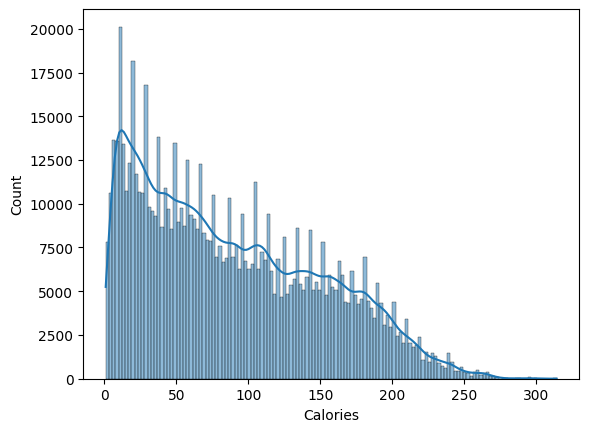

In [7]:
sns.histplot(train['Calories'], kde=True)

## Data Cleaning and Preprocessing

Null values

In [8]:
train.isnull().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

### Encoding Columns

In [9]:
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

In [10]:
train['Sex'].dtype

dtype('int64')

# Feature Engineering

In [11]:
for df in [train, test]:
    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    df['HR_per_min'] = df['Heart_Rate'] / df['Duration']
    df['Temp_per_min'] = df['Body_Temp'] / df['Duration']
    df['Effort'] = df['Heart_Rate'] * df['Body_Temp'] * df['Duration']
    df['Age_Weight'] = df['Age'] * df['Weight']
    df['Weight_per_height'] = df['Weight'] / df['Height']
    df['Age_Bin'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 60, 100], labels=False)
    df['Duration_squared'] = df['Duration'] ** 2
    df['HR_Temp_ratio'] = df['Heart_Rate'] / (df['Body_Temp'] + 1)
    df['Age_Duration'] = df['Age'] * df['Duration']
    df['log_Duration'] = np.log1p(df['Duration'])

In [12]:
features = [
    'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
    'BMI', 'HR_per_min', 'Temp_per_min', 'Effort',
    'Age_Weight', 'Weight_per_height',
    'Age_Bin', 'Duration_squared', 'HR_Temp_ratio', 'Age_Duration', 'log_Duration'
]


X = train[features]
y = np.log1p(train["Calories"])  # Target in log scale
X_test = test[features]

Preprocessor creation

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import xgboost

In [14]:
numeric_features = [col for col in features if col != 'Sex']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features)
], remainder='passthrough')

# Model Training

In [17]:
from catboost import CatBoostRegressor

# Define CatBoost model
catboost_model = CatBoostRegressor(
    iterations=600,           
    learning_rate=0.03,        
    depth=8,                   
    l2_leaf_reg=3,             
    random_seed=42,  
    loss_function='RMSE',      
    eval_metric='RMSE',        
    
)


In [18]:
xgb_params = {
    'objective': 'reg:squaredlogerror',  
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bytree': 0.7,
    'eval_metric': 'rmsle'
}

model = xgboost.XGBRegressor(
    **xgb_params,
    n_estimators=600,         
    n_jobs=-1
)
# model.fit(X_train_preprocessed, y_train)

# KFold Evaluation

In [19]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Parameters
RANDOM_STATE = 42
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Arrays to store OOF and test predictions
oof_xgb = np.zeros(len(X))
oof_cat = np.zeros(len(X))
test_preds_xgb = np.zeros(len(X_test))
test_preds_cat = np.zeros(len(X_test))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f'🔁 Fold {fold + 1}/{N_FOLDS}')

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # XGBoost pipeline
    pipe_xgb = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])

    # CatBoost pipeline
    pipe_cat = Pipeline([
        ('pre', preprocessor),
        ('model', catboost_model)
    ])

    # Fit models
    pipe_xgb.fit(X_train, y_train)
    pipe_cat.fit(X_train, y_train)

    # Predict OOF
    oof_xgb[valid_idx] = pipe_xgb.predict(X_valid)
    oof_cat[valid_idx] = pipe_cat.predict(X_valid)

    # Predict test (average over folds)
    test_preds_xgb += pipe_xgb.predict(X_test) / N_FOLDS
    test_preds_cat += pipe_cat.predict(X_test) / N_FOLDS

# ✅ CV Scores
rmsle_xgb = np.sqrt(mean_squared_log_error(y, oof_xgb))
rmsle_cat = np.sqrt(mean_squared_log_error(y, oof_cat))

print(f'\n✅ XGBoost CV RMSLE: {rmsle_xgb:.4f}')
print(f'✅ CatBoost CV RMSLE: {rmsle_cat:.4f}')

🔁 Fold 1/5
0:	learn: 0.9358655	total: 134ms	remaining: 1m 20s
1:	learn: 0.9090029	total: 204ms	remaining: 1m 1s
2:	learn: 0.8830378	total: 275ms	remaining: 54.7s
3:	learn: 0.8579734	total: 346ms	remaining: 51.5s
4:	learn: 0.8336083	total: 419ms	remaining: 49.8s
5:	learn: 0.8099499	total: 487ms	remaining: 48.2s
6:	learn: 0.7870723	total: 558ms	remaining: 47.3s
7:	learn: 0.7647524	total: 627ms	remaining: 46.4s
8:	learn: 0.7430490	total: 696ms	remaining: 45.7s
9:	learn: 0.7220629	total: 767ms	remaining: 45.3s
10:	learn: 0.7017501	total: 836ms	remaining: 44.8s
11:	learn: 0.6821235	total: 903ms	remaining: 44.3s
12:	learn: 0.6630112	total: 972ms	remaining: 43.9s
13:	learn: 0.6444134	total: 1.04s	remaining: 43.6s
14:	learn: 0.6265122	total: 1.11s	remaining: 43.4s
15:	learn: 0.6090045	total: 1.18s	remaining: 43.1s
16:	learn: 0.5920021	total: 1.25s	remaining: 43s
17:	learn: 0.5755250	total: 1.32s	remaining: 42.8s
18:	learn: 0.5596136	total: 1.39s	remaining: 42.5s
19:	learn: 0.5441522	total: 1.4

## Ensemble Blending

Finding Best weights

In [20]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Stack OOF predictions
oof_meta_X = np.vstack([oof_cat, oof_xgb]).T

# RMSLE Loss
def rmsle_loss(weights):
    blended = oof_meta_X @ weights
    return np.sqrt(mean_squared_log_error(y, blended))

# Constraints: weights sum to 1
constraints = {'type': 'eq', 'fun': lambda w: w.sum() - 1}
bounds = [(0, 1) for _ in range(oof_meta_X.shape[1])]

# Start from slightly different weights to help optimizer
initial_weights = np.array([0.6, 0.4])

# Optimize
result = minimize(rmsle_loss, initial_weights, bounds=bounds, constraints=constraints, method='SLSQP', options={'ftol':1e-9, 'disp':True})
best_weights = result.x
print(f'✅ Best Ensemble Weights: {best_weights}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.017082281782285037
            Iterations: 7
            Function evaluations: 21
            Gradient evaluations: 7
✅ Best Ensemble Weights: [0.44066722 0.55933278]


In [21]:
# Stack test predictions
test_meta_X = np.vstack([test_preds_cat, test_preds_xgb]).T

# Apply best weights
final_pred_log = test_meta_X @ best_weights
final_pred = np.expm1(final_pred_log)  # Reverse log1p

# Done: final_pred is my submission prediction

# Final Evaluation on test data

In [23]:
# Prepare submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],  # use test IDs provided
    'Calories': final_pred  # predicted calories
})

# Save submission file
submission.to_csv('submission file.csv', index=False)

print("Submission file saved as 'submission file.csv'")


Submission file saved as 'submission file.csv'
